# TERA - Aula 28
## Sistemas de Recomendação

Objetivos gerais da aula:
- Apresentar técnicas clássicas de sistemas de recomendação
- Redução de dimensionalidade
- Análise de tópicos

# Índice

- [Recomendação Baseada em Conteúdo](#Recomendação-Baseada-em-Conteúdo)
    - [Case 1: Recomendação de artigos](#Exemplo-Inicial)
- [Redução de dimensionalidade](#Redução-de-Dimensionalidade)
    - [PCA](#Principal-Component-Analysis-PCA)
    - [Visualização T-SNE](#T-SNE)
- [Topic Analysis](#Topic-Analysis)
    - [NMF](#Non-Negative-Matrix-Factorization-NMF)
    - [LDA](#Latent-Dirichlet-Allocation-LDA)
- [Recomendação Filtro Colaborativo](#Recomendação-com-Filtro-Colaborativo)
    - [Baseado em Memória](#Filtro-colaborativo-baseado-em-memória)
    - [Baseado em Modelo](#Filtro-colaborativo-baseado-em-modelo)

In [93]:
# Imports usados no curso
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set(style="ticks")
plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.style.use('seaborn-colorblind')

In [2]:
# Pasta contendo os dados:
ROOT_FOLDER = os.path.realpath('..')
DATASET_FOLDER = os.path.join(ROOT_FOLDER,'datasets')

# Introdução

Em poucos anos a internet revolucionou o mercado de consumo mundial e a forma como os clientes interagem com os vendedores. Uma das dinâmicas criadas mais importantes a partir dessa revolução é a de sistemas de recomendação. Todos devem já ter notado o quanto e-commerces como a Amazon, Best Buy e até empresas brasileiras acertam ao recomendar certos tipos de produto para seus clientes, que muitas vezes nem os estavam procurando (veja esse [artigo](https://www.techemergence.com/use-cases-recommendation-systems/)). Isso não acontece mais apenas em e-commerces, mas também com provedores de música (Spotify), de filmes (Netflix) ou vídeos em geral (Youtube). 

Esse fenômeno só ocorre devido a um fator: **dados**. As empresas atualmente possuem muita informação sobre os seus produtos e os seus usuários. É muito fácil obter, hoje em dia, os interesses dos clientes sobre seus produtos. Seja o fato de o vendedor comprar um produto, dar um review ou apenas clicar, já é suficiente para uma empresa mapear os interesses dos usuários e tentar direcionar produtos que seriam relevantes para o usuário sem nem mesmo ele saber!

Os sistemas de recomendação se baseiam, basicamente, em encontrar relações entre compradores e produtos. Mais especificamente, existem dois grandes grupos de sistemas de recomendação:
- **Proximidade de produtos**: Tem o objetivo de encontrar produtos similares aos consumidos por um cliente. Se um cliente possui o interesse em um determinado produto, o sistema de recomendação pode tentar encontrar outros produtos similares para indicar para o cliente.
- **Proximidade entre clientes** (Filtro Colaborativo): Tem o objetivo de encontrar clientes com interesses semelhantes. Suponha que exista um cliente X que consuma os produtos A e B, enquanto um outro cliente Y tem interesse nos produtos A, B e C. Como eles possuem interesses semelhantes (produtos A e B), o sistema de recomendação poderia indicar o produto C para o cliente X.

Existem diversos outros tipos de sistemas de recomendação que fogem do escopo desse material. Mais informações podem ser vistas nesse [link](https://www.techemergence.com/use-cases-recommendation-systems/).

---
# Recomendação Baseada em Conteúdo

## Exemplo inicial
- **Case: Recomendação Artigos NY Times**

Esse case foi retirado deste [artigo](https://towardsdatascience.com/topic-modeling-for-the-new-york-times-news-dataset-1f643e15caac). O objetivo dele é verificar se conseguimos recomendar artigos para um usuário. O dataset contém 8.447 matérias do NY Times, com um vocabulário de 3.012 palavras. Por razão de direitos autorias, os documentos não possuem título.

<img src="https://cdn-images-1.medium.com/max/1400/1*toWf7lAVf_5GIb9IMfS8Bw.jpeg" alt="Drawing" style="width: 800px;"/>

O arquivo `nyt_dataset.csv` contém os documentos, onde cada linha representa um documento específico e cada coluna representa a frequência de cada palavra. O dataset já sofreu um processo de limpeza e vetorização, onde foram mantidas apenas palavras que ocorreram mais de 10 vezes.

Vamos criar a matriz de frequências a partir desses dados:

In [3]:
df_nyt = pd.read_csv(os.path.join(DATASET_FOLDER, 'nyt_dataset.csv'), sep=';')

df_nyt.head()

,company,percent,state,play,official,game,man,city,plan,school,...,speculate,thrill,spur,vivid,exact,helpful,distinguish,glad,harder,lucrative
0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
X = df_nyt.values

In [5]:
print('Esparsidade: {:.2%}'.format(len(X[X==0])/np.prod(X.shape)))

Esparsidade: 96.21%


Podemos perceber que os dados são muito esparsos, isso é, a matriz de `items x palavras` possui muitos valores vazios (contagem igual a 0).

Vamos agora criar um embedding da matriz de frequência de termos utilizando tf-idf.

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()

X_tfidf = tfidf.fit_transform(X)

In [7]:
X_tfidf.shape

(8447, 3012)

Suponha agora que temos um usuário e ele leu o seguinte artigo:

In [8]:
# Esse documento será o escolhido pelo cliente
#doc_target = np.random.choice(range(len(df_nyt)))
doc_target = 3644
doc_target

3644

In [9]:
# Verifica as principais palavras que o documento contém:
doc_target_features = df_nyt.iloc[doc_target]
print(doc_target_features.sort_values(ascending=False)[:20])

wear          2.0
fashion       2.0
jacket        2.0
black         2.0
brown         2.0
store         2.0
wait          1.0
fully         1.0
department    1.0
finish        1.0
president     1.0
suddenly      1.0
red           1.0
dress         1.0
weekend       1.0
big           1.0
direction     1.0
close         1.0
body          1.0
cut           1.0
Name: 3644, dtype: float64


Que outro artigo você recomendaria para esse usuário? Consegue imaginar uma forma simples?

In [10]:
#TODO

## Solução
## Calcular a similaridade de cossenos desse artigo em relação a todos os outros e retornar os mais similares.
## Se o usuário gostou desse artigo (consumiu), provavelmente gostará de outros semelhantes.

# Passo 1: Calcula, para cada par, a similaridade de cossenos
from sklearn.metrics.pairwise import cosine_similarity

# Matriz quadrada NxN (N = número de documentos) -> distância entre cada item (diagonal = 1)
similarity_matrix = cosine_similarity(X_tfidf)
print('Tamanho matrix de similaridade: {}'.format(similarity_matrix.shape))

# Passo 2: Pegar a linha referente ao documento consumido e verificar quais produtos são mais semelhantes a ele
recommended_doc_indices = np.argsort(similarity_matrix[doc_target,:])[::-1]

# Passo 3: Escolher top 5 documentos para apresentar ao usuário
recommended_doc_indices = recommended_doc_indices[1:6] # elimina o próprio documento
print('Artigo consumido: doc {}'.format(doc_target))
print('---------------------------')
print('\tPalavras comuns: {}\n'.format(doc_target_features.sort_values(ascending=False)[:5].index.tolist()))

print('Recomendação')
print('---------------------------')
for i, rec_idx in enumerate(recommended_doc_indices):
    print('- {}) Doc {}'.format(i,rec_idx))
    print('Similaridade: {:.3%}'.format(similarity_matrix[doc_target,rec_idx]))
    common_words = df_nyt.iloc[rec_idx].sort_values(ascending=False)[:5].index.tolist()
    print('Palavras comuns: {}'.format(common_words))
    print('-'*27+'\n')

Tamanho matrix de similaridade: (8447, 8447)
Artigo consumido: doc 3644
---------------------------
	Palavras comuns: ['wear', 'fashion', 'jacket', 'black', 'brown']

Recomendação
---------------------------
- 0) Doc 5664
Similaridade: 36.845%
Palavras comuns: ['black', 'leg', 'white', 'fashion', 'vice']
---------------------------

- 1) Doc 7109
Similaridade: 33.219%
Palavras comuns: ['dress', 'dinner', 'evening', 'black', 'white']
---------------------------

- 2) Doc 5234
Similaridade: 29.213%
Palavras comuns: ['jacket', 'woman', 'fashion', 'odd', 'hide']
---------------------------

- 3) Doc 5570
Similaridade: 28.430%
Palavras comuns: ['skirt', 'design', 'short', 'check', 'pair']
---------------------------

- 4) Doc 1498
Similaridade: 28.008%
Palavras comuns: ['dress', 'clothes', 'add', 'top', 'short']
---------------------------



O que achou do primeiro sistema de recomendação? Talvez as similaridades estejam meio baixas, não acha? Consegue explicar o porquê?

Resposta: Alta dimensionalidade + esparsidade!

- **Problema 1**:
Quanto mais dimensões tem o sistema, menor é a relação de distância entre os documentos, fator esse que é conhecido como a "maldição da dimensionalidade". Além disso, a alta esparsidade dos dados faz com que a similaridade de cossenos seja sempre baixa. 
    
    **Solução**: Técnicas de redução de dimensionalidade.


- **Problema 2**:
Outro fator importante a se notar é que ao utilizar a similaridade de cossenos diretamente, palavras semelhantes, mas com tokens diferentes, serão ignoradas. Por exemplo, suponha que temos dois documentos `a = [casamento, filho, flores]` e `b = [matrimonio, filha, rosa]`. Se calcularmos a similaridade de cossenos deles, a similaridade seria 0! 

    **Solução**:
Existe a possibilidade de criarmos um modelo que normaliza as palavras em função de sua semântica, mas isso seria trabalhoso e inviável para alguns casos. A outra possibilidade é utilizar uma técnica chamada de ["Análise de Tópicos"](https://en.wikipedia.org/wiki/Topic_model), em que procuramos encontrar tópicos (temas ou variáveis implícitas) nos documentos. Essa técnica é basicamente um método de clustering dos termos e documentos, onde procuramos sumarizar os dados em partes menores ou tópicos.

---
# Redução de Dimensionalidade

A redução de dimensionalidade tem o objetivo de encontrar uma representação mais simplificada, porém representativa, dos dados com alta dimensionalidade. Esta técnica pode ser resolver três problemas principais:
- reduzir efeitos da maldição da dimensionalidade
- reduzir carga computacional de algoritmos de machine learning
- visualização: projeção de dados multidimensionais em 2D/3D

## Principal Component Analysis PCA

O [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) é uma das técnicas mais utilizadas em Machine Learning para encontrar representações sumarizadas sobre os problemas de alta dimensionalidade. O PCA procura descorrelacionar linearmente os atributos do sistema, encontrando assim os **componentes principais**. Cada componente pode ser visto como um novo vetor de atributos que é formado pela combinação linear dos atributos originais. Os componentes principais são ordenados de forma que o primeiro componente representa a região de maior variância do sistema, o segundo representa a segunda maior e é ortogonal ao primeiro, e assim sucessivamente.

O algoritmo básico do PCA realiza 4 passos fundamentais para transformar o espaço de atributos e achar os componentes princiais:

1. Remove a média amostral
2. Rotaciona os eixos para descorrelacionar os dados
3. Ordena os componentes principais por nível de variância (importância)
4. Elimina os componentes menos variantes (Opcional - redução de dimensionalidade)

A implementação do PCA no sklearn pode ser encontrada neste [link](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

### Exemplo
- **Variedades de grãos de trigo**

Vamos utilizar o dataset de diferentes tipos de grãos de trigo obtidos pelo [UCI](https://archive.ics.uci.edu/ml/datasets/seeds#) para testar o PCA.

<img src="https://kaggle2.blob.core.windows.net/datasets-images/904/1650/133a751e78dabf09031d6adfa0075ae0/dataset-original.jpg" width="400" height="100" />

Esse dataset contém medidas de raio-x de três variedades de grãos de trigo.

O dataset contém os seguintes parâmetros:

- `area`: Área total do grão, A
- `perimeter`: Perímetro do grão, P
- `compactness`: Grão de compactação do grão - $C = \frac{4 \pi A}{P^2}$
- `length_kernel`: Comprimento do núcleo
- `width_kernel`: Largura do núcleo
- `asymmetry`: Coeficiente de assimetria
- `kernel_groove`: Comprimento do sulco do núcleo

Variedades de grãos: 'Kama' (1), 'Rosa' (2) e 'Canadian' (3)

O dataset possui 7 dimensões. Mas, será que não conseguimos representar esses dados de maneira mais compacta?

In [11]:
# Importar os dados
df_grain = pd.read_csv(os.path.join(DATASET_FOLDER, 'seeds_dataset.csv'), sep=';')
df_grain.head(5)

,area,perimeter,compactness,length_kernel,width_kernel,asymmetry,kernel_groove,varieties
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,Kama
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,Kama
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,Kama
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,Kama
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,Kama


A maneira tradicional de verificar a distribuição dos dados é visualizar a matriz de gráficos pareados.

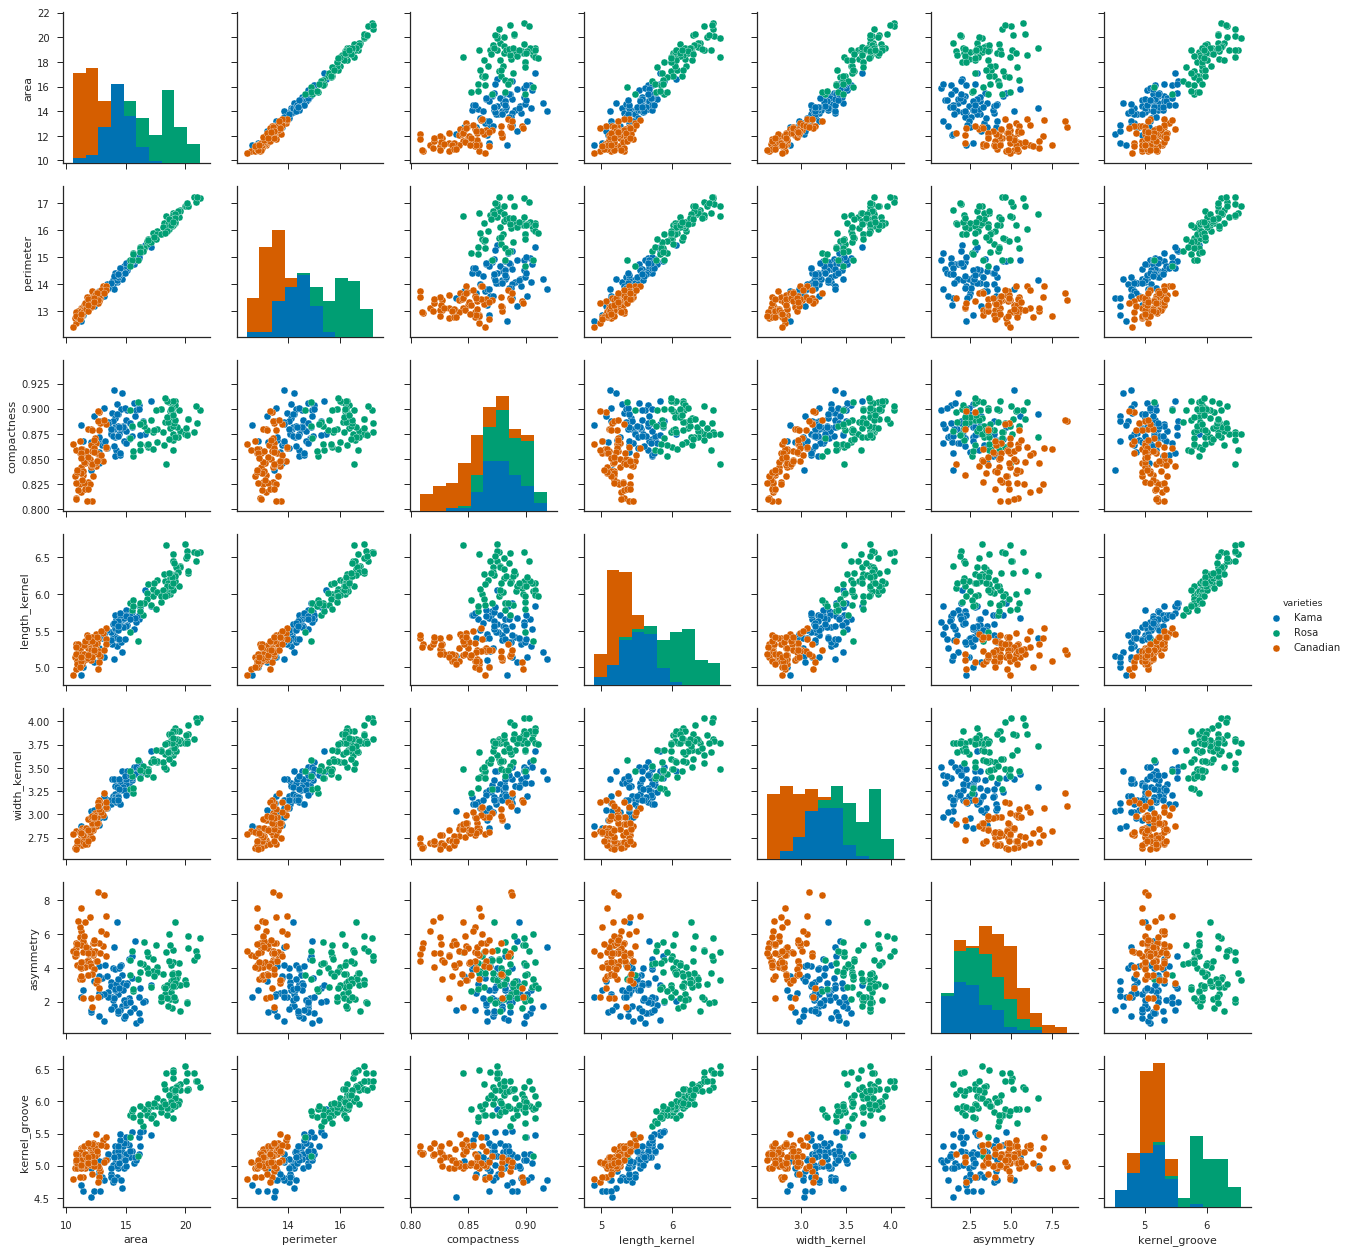

In [12]:
sns.pairplot(df_grain, hue='varieties')
plt.show()

Com 7 dimensões ainda conseguimos visualizar as correlações entre as variáveis, mas é um pouco complicado. Será que não conseguimos criar uma representação mais compacta dos dados, mas ainda mantendo a quantidade de informação? R: Sim!

In [13]:
from sklearn.preprocessing import StandardScaler

X = df_grain.drop('varieties',1).values

# Normaliza os dados
normalizer = StandardScaler()

X_scaled = normalizer.fit_transform(X)

In [14]:
from sklearn.decomposition import PCA

pca = PCA()

X_pca = pca.fit_transform(X_scaled)

X_pca.shape

(210, 7)

In [15]:
# Transforma as labels em valores numéricos
from sklearn.preprocessing import LabelEncoder

labels = LabelEncoder().fit_transform(df_grain['varieties'].values)

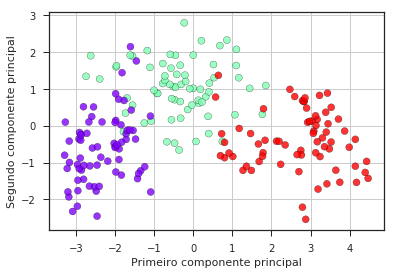

In [16]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='rainbow', alpha=0.8, edgecolor='k')
plt.xlabel('Primeiro componente principal')
plt.ylabel('Segundo componente principal')
plt.grid()
plt.show()

O que achou? Esses dois eixos nos mostram uma boa separação de cada variedade de grãos.

Outra coisa que podemos fazer é verificar o quanto cada eixo representa da variância do modelo, ou também chamado de **variância explicada** pelo componente.

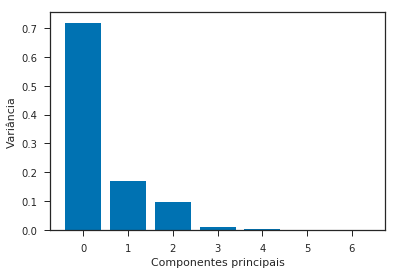

Variância explicada: 
--------------------------------------------------
1 Componente(s) principal(is): 71.87%
2 Componente(s) principal(is): 88.98%
3 Componente(s) principal(is): 98.67%
4 Componente(s) principal(is): 99.64%
5 Componente(s) principal(is): 99.91%
6 Componente(s) principal(is): 99.99%
7 Componente(s) principal(is): 100.00%


In [17]:
# Componentes principais
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_)
plt.xticks(features)
plt.xlabel('Componentes principais')
plt.ylabel('Variância')
plt.show()

print('Variância explicada: ')
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)

print('-'*50)
for i in range(len(pca.explained_variance_ratio_)):
    print('{} Componente(s) principal(is): {:.2%}'.format(i+1, cum_exp_var[i]))

Utilizando apenas os 2 primeiros componentes, nós já podemos ter quase 90% da variância explicada. Isso significa que poderíamos reduzir de 7 para 2 dimensões e manter quase toda a quantidade de informação dos dados!

### Voltando ao exemplo do NY Times

Vamos agora tentar aplicar o método PCA no problema anterior e verificar se conseguimos melhorar o sistema de recomendação!

Como o algoritmo implementado na função PCA do scikit-learn não suporta matrizes esparsas, nós precisamos utilizar a função [`TruncatedSVD`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). A única diferença desse algoritmo em relação ao PCA é o fato de ele não retirar a média dos dados antes de encontrar os componentes principais.

In [18]:
df_nyt = pd.read_csv(os.path.join(DATASET_FOLDER, 'nyt_dataset.csv'), sep=';')

df_nyt.head()

,company,percent,state,play,official,game,man,city,plan,school,...,speculate,thrill,spur,vivid,exact,helpful,distinguish,glad,harder,lucrative
0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
X = df_nyt.values

In [20]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=X.shape[1]-1)

In [21]:
X_svd = svd.fit_transform(X_tfidf)

Vamos agora encontrar a variância explicada pelos componentes principais.

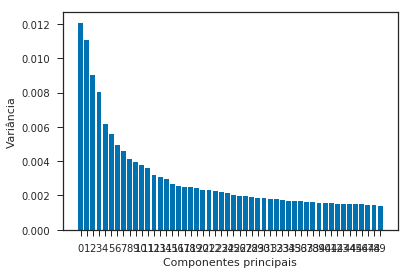

In [22]:
# Componentes principais
features = range(svd.components_.shape[1]-1)

# Ordena os componentes - diferente do PCA que já vem ordenado
exp_var = np.sort(svd.explained_variance_ratio_)[::-1]

# Apresenta apenas os 50 primeiros
plt.bar(features[:50], exp_var[:50])
plt.xticks(features[:50])
plt.xlabel('Componentes principais')
plt.ylabel('Variância')
plt.show()

In [23]:
print('Variância explicada: ')
cum_exp_var = np.cumsum(exp_var)[:2000]

print('-'*50)
for i in range(0,len(exp_var[:2000]),100):
    print('{} Componente(s) principal(is): {:.2%}'.format(i+1, cum_exp_var[i]))

Variância explicada: 
--------------------------------------------------
1 Componente(s) principal(is): 1.21%
101 Componente(s) principal(is): 21.19%
201 Componente(s) principal(is): 30.10%
301 Componente(s) principal(is): 37.40%
401 Componente(s) principal(is): 43.75%
501 Componente(s) principal(is): 49.36%
601 Componente(s) principal(is): 54.39%
701 Componente(s) principal(is): 58.93%
801 Componente(s) principal(is): 63.05%
901 Componente(s) principal(is): 66.80%
1001 Componente(s) principal(is): 70.23%
1101 Componente(s) principal(is): 73.37%
1201 Componente(s) principal(is): 76.24%
1301 Componente(s) principal(is): 78.88%
1401 Componente(s) principal(is): 81.29%
1501 Componente(s) principal(is): 83.51%
1601 Componente(s) principal(is): 85.54%
1701 Componente(s) principal(is): 87.40%
1801 Componente(s) principal(is): 89.10%
1901 Componente(s) principal(is): 90.65%


Podemos verificar que conseguiríamos reduzir consideravelmente a dimensão do problema! Agora podemos utilizar tanto o método do cotovelo quanto um corte baseado na variância explicada do sistema. Vamos testar a utilização de 100 componentes principais e verificar como fica o resultado.

In [24]:
# teste outros valores de numero de componentes para verificar o resultado
# Note que quanto menor, maior é o valor das similaridades encontradas. Isso faz sentido?
svd = TruncatedSVD(n_components=100)

X_svd = svd.fit_transform(X_tfidf)

X_svd.shape

(8447, 100)

In [25]:
# Passo 1: Encontra a matriz de similaridade de cossenos
# Matriz quadrada NxN (N = número de documentos) -> distância entre cada item (diagonal = 1)
similarity_matrix = cosine_similarity(X_svd)

# Passo 2: Pegar a linha referente ao documento consumido e verificar quais produtos são mais semelhantes a ele
recommended_doc_indices = np.argsort(similarity_matrix[doc_target,:])[::-1]

# Passo 3: Escolher top 5 documentos para apresentar ao usuário
top_recommended_doc_indices = recommended_doc_indices[1:6] # elimina o próprio documento
print('Artigo consumido: doc {}'.format(doc_target))
print('---------------------------')
print('\tPalavras comuns: {}\n'.format(doc_target_features.sort_values(ascending=False)[:5].index.tolist()))

print('Recomendação')
print('---------------------------')
for i, rec_idx in enumerate(top_recommended_doc_indices):
    print('- {}) Doc {}'.format(i,rec_idx))
    print('Similaridade: {:.3%}'.format(similarity_matrix[doc_target,rec_idx]))
    common_words = df_nyt.iloc[rec_idx].sort_values(ascending=False)[:5].index.tolist()
    print('Palavras comuns: {}'.format(common_words))
    print('-'*27+'\n')

Artigo consumido: doc 3644
---------------------------
	Palavras comuns: ['wear', 'fashion', 'jacket', 'black', 'brown']

Recomendação
---------------------------
- 0) Doc 5570
Similaridade: 90.622%
Palavras comuns: ['skirt', 'design', 'short', 'check', 'pair']
---------------------------

- 1) Doc 5664
Similaridade: 87.646%
Palavras comuns: ['black', 'leg', 'white', 'fashion', 'vice']
---------------------------

- 2) Doc 5701
Similaridade: 84.223%
Palavras comuns: ['wear', 'widely', 'designer', 'woman', 'band']
---------------------------

- 3) Doc 7109
Similaridade: 82.966%
Palavras comuns: ['dress', 'dinner', 'evening', 'black', 'white']
---------------------------

- 4) Doc 1498
Similaridade: 82.850%
Palavras comuns: ['dress', 'clothes', 'add', 'top', 'short']
---------------------------



Vamos visualizar os dados com apenas os dois eixos principais:

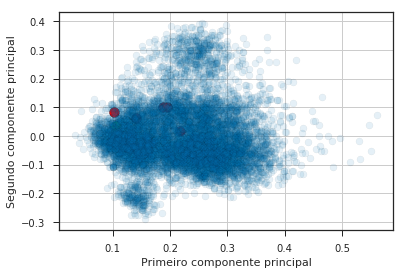

In [26]:
plt.scatter(X_svd[recommended_doc_indices[0], 0], X_svd[recommended_doc_indices[0], 1], c=(0,1,0), edgecolor='k', s=100)
plt.scatter(X_svd[recommended_doc_indices[1:6], 0], X_svd[recommended_doc_indices[1:6], 1], c=(1,0,0), edgecolor='k', s=100)
plt.scatter(X_svd[:, 0], X_svd[:, 1], alpha=0.1, edgecolor='k')
plt.xlabel('Primeiro componente principal')
plt.ylabel('Segundo componente principal')
plt.grid()
plt.show()

Podemos perceber os dados bem distribuídos, mas ainda não é possível notar uma estrutura próxima entre eles. Isso era esperado, já que os dois primeiros componentes principais só contém cerca de 2% da variância explicada. Para plotar esse gráfico, nós podemos utilizar outra ferramenta poderosa: o T-SNE.

---
# T-SNE

[T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) é um algoritmo de machine learning iterativo que procura mapear regiões multidimensionais em 2 ou 3 dimensões. O resultado gerado pelo método é um mapa de dispersão na qual os pontos com maior afinidade (mesma estrutura) estão próximos, enquanto os pontos dissimilares ficam distantes. Note que os eixos não têm necessariamente um significado predeterminado. Não podemos calcular distâncias entre pontos a partir do resultado do T-SNE.

Normalmente, o T-SNE é utilizado para visualização de dados. Podemos mapear problemas de alta dimensionalidade em 2 ou 3 dimensões, onde garantimos que a sua estrutura se manterá.

In [27]:
# Vamos agora importar o método T-SNE do scikit-learn
from sklearn.manifold import TSNE

#### Dataset variedade de grãos de trigo

In [28]:
X = df_grain.drop('varieties',1).values

X_scaled = normalizer.fit_transform(X)

# Codifica variedades em valores numéricos
label_encoder = LabelEncoder()
varieties = label_encoder.fit_transform(df_grain['varieties'].values)

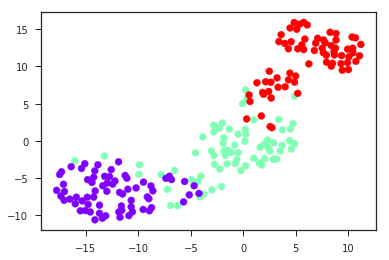

In [29]:
# Execute o T-SNE
# Crie a instância do T-SNE
# Teste diferentes valores de learning_rate e perplexity
tsne = TSNE(learning_rate=200, perplexity=30)

# Transforme os dados
X_tsne = tsne.fit_transform(X)

# Agora basta plotar o resultado
plt.scatter(X_tsne[:,0], 
            X_tsne[:,1], 
            c=varieties, 
            cmap='rainbow')
plt.show()

### Artigos do Wikipedia

[pular](#Case-Elo7:-Motivos-de-compra)

O dataset que vamos utilizar foi retirado desse [link](https://blog.lateral.io/2015/06/the-unknown-perils-of-mining-wikipedia/). O dataset original contém 463 mil páginas do Wikipedia de diversos temas. Para não ficarmos o dia inteiro processando os dados, foram retirados apenas 58 artigos de classes bem definidas (por exemplo, futebol, música, internet etc). Vamos analisar o dataset:

In [30]:
df_wiki = pd.read_csv(os.path.join(DATASET_FOLDER, 'wikipedia_dataset.csv'), sep=';')

df_wiki.head()

,titulo,artigo,cluster
0,Black Sabbath,"Black Sabbath are an English rock band, formed...",Music
1,Lymphoma,Lymphoma is a type of blood cancer that occurs...,Sickness
2,Hepatitis C,Hepatitis C is an infectious disease affecting...,Sickness
3,HTTP cookie,"A cookie, also known as an HTTP cookie, web co...",Internet
4,Global warming,Global warming is the rise in the average temp...,Global_Warming


A coluna de clusters foi feita de maneira a facilitar nosso entendimento sobre o resultado final do algoritmo. Na maioria dos casos nós não teremos esse entendimento antes de realizar uma primeira análise (clustering) dos algoritmos.

Vamos tentar aplicar os métodos PCA para reduzir a dimensionalidade desse problema e o T-SNE para visualização.

Mas, primeiro, precisamos criar a matriz de atributos. Para isso, vamos utilizar o TF-IDF.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.8, max_features=15000, sublinear_tf=True, use_idf=True)

In [32]:
# Aplique a transformação nos artigos
X = tfidf.fit_transform(df_wiki['artigo'].values)

# Tamanho do dataset
X.shape

(58, 15000)

Como temos 15000 dimensões, nós podemos ter problemas com a tal da *maldição da dimensionalidade*. Além disso, a probabilidade de cada uma das palavras estar dentro de todos os documentos é muito baixa. Ou seja, a matriz de atributos é muito esparsa. Isso nos dá um indício forte para acreditar que teremos grandes vantagens se utilizarmos uma técnica para reduzir a dimensionalidade, como o PCA.

In [33]:
# Vamos utilizar o TruncatedSVD para reduzir a dimensionalidade do dataset.
# Podemos limitar o número de components para ser igual ao número
# de dados: 58
# Desse modo temos uma matriz quadrada
svd = TruncatedSVD(n_components=58)

# Aplique o método SVD
X_svd = svd.fit_transform(X)

# Vamos ver como ficou o novo tamanho
X_svd.shape

(58, 58)

É uma redução bastante drástica! Reduzimos de 15000 dimensões para apenas 58. Será que perdemos muita informação? Vamos verificar o gráfico de variância explicada.

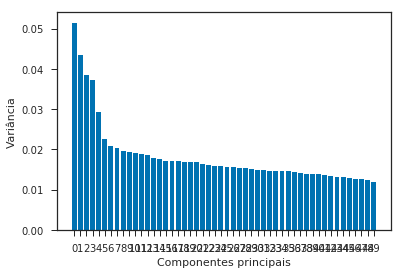

In [34]:
# Componentes principais
features = range(svd.components_.shape[1]-1)

# Ordena os componentes - diferente do PCA que já vem ordenado
exp_var = np.sort(svd.explained_variance_ratio_)[::-1]

# Apresenta apenas os 50 primeiros
plt.bar(features[:50], exp_var[:50])
plt.xticks(features[:50])
plt.xlabel('Componentes principais')
plt.ylabel('Variância')
plt.show()

In [35]:
print('Variância explicada: ')
cum_exp_var = np.cumsum(exp_var)

print('-'*50)
for i in range(0,len(exp_var),10):
    print('{} Componente(s) principal(is): {:.2%}'.format(i+1, cum_exp_var[i]))

Variância explicada: 
--------------------------------------------------
1 Componente(s) principal(is): 5.15%
11 Componente(s) principal(is): 32.22%
21 Componente(s) principal(is): 49.68%
31 Componente(s) principal(is): 65.32%
41 Componente(s) principal(is): 79.65%
51 Componente(s) principal(is): 92.41%


Podemos ver que ao utilizar 50 componentes, nós já teríamos aproximadamente 90% da variância explicada. Isso nos mostra que poderíamos reduzir ainda mais o número de dimensões escolhidas.

Vamos agora plotar o gráfico T-SNE para verificar a estrutura dos dados.

In [36]:
tsne = TSNE(learning_rate=5)

X_tsne = tsne.fit_transform(X_svd)

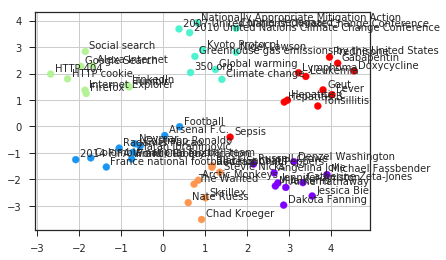

In [37]:
labels = LabelEncoder().fit_transform(df_wiki['cluster'].values)

plt.scatter(X_tsne[:, 0],
            X_tsne[:, 1],
            c=labels,
            cmap='rainbow')

for i in range(X_tsne.shape[0]):
    # Anota os motivos no gráfico
    plt.annotate(df_wiki['titulo'][i], 
                 ((X_tsne[i, 0], X_tsne[i, 1])),
                 xytext=(4, 3), 
                 textcoords='offset points')
plt.grid()
plt.show()

Nós conseguímos apresentar dados de 15000 dimensões em apenas duas e, ainda assim, verificar a presença de uma estrutura bem definida entre os clusters. Incrível, não?

### Case Elo7: Motivos de compra

Agora tente aplicar os métodos PCA e T-SNE para encontrar relações entre os dados. Utilize as ferramentas apresentadas anteriormente para gerar um bom entendimento sobre o problema.

In [38]:
df_reason = pd.read_csv(os.path.join(DATASET_FOLDER, 'purchase_reason_elo7_dataset.csv'), sep=';')

df_reason.head(10)

,product_title,reason
0,apliques recortados fundo do mar,festa de 2 anos do meu filho
1,mini raposa vermelha amigurumi,presente para mim
2,o pequeno principe i bata,aniversario
3,quadro maternidade menino elefante,nascimento do meu bebe
4,livro de votos casamento o par,casamento
5,caixa 40 charuto de chocolate belga,lembranca de maternidade
6,arquivo de corte vamos brindar,mimo para mim
7,prateleira com varao mdf reta 96x20x14,decoracao do quarto da minha filha
8,colherzinha bailarina,aniversario
9,caixa cone arvore jardim dos passarinhos,festa


In [39]:
X = tfidf.fit_transform(df_reason['reason'].values)

Aplique os métodos PCA e T-SNE.

In [40]:
# Execute o PCA (TruncatedSVD)
# Encontre uma região de corte para reduzir a dimensionalidade
svd = TruncatedSVD(n_components=X.shape[1]-1)

# Aplique o método SVD
X_svd = svd.fit_transform(X)

# Vamos ver como ficou o novo tamanho
X_svd.shape

(100000, 495)

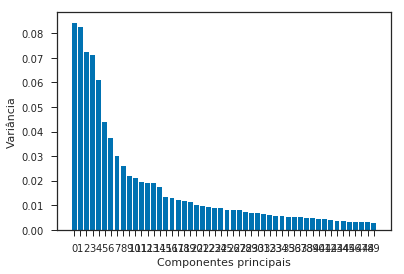

In [41]:
# Componentes principais
features = range(svd.components_.shape[1]-1)

# Ordena os componentes - diferente do PCA que já vem ordenado
exp_var = np.sort(svd.explained_variance_ratio_)[::-1]

# Apresenta apenas os 50 primeiros
plt.bar(features[:50], exp_var[:50])
plt.xticks(features[:50])
plt.xlabel('Componentes principais')
plt.ylabel('Variância')
plt.show()

In [42]:
print('Variância explicada: ')
cum_exp_var = np.cumsum(exp_var[:100])

print('-'*50)
for i in range(0,len(exp_var[:100]),10):
    print('{} Componente(s) principal(is): {:.2%}'.format(i+1, cum_exp_var[i]))

Variância explicada: 
--------------------------------------------------
1 Componente(s) principal(is): 8.43%
11 Componente(s) principal(is): 55.14%
21 Componente(s) principal(is): 69.78%
31 Componente(s) principal(is): 78.00%
41 Componente(s) principal(is): 83.29%
51 Componente(s) principal(is): 86.70%
61 Componente(s) principal(is): 88.82%
71 Componente(s) principal(is): 90.32%
81 Componente(s) principal(is): 91.49%
91 Componente(s) principal(is): 92.49%


Podemos perceber que poderíamos facilmente utilizar apenas 70 dimensões. Isso já nos daria uma variância explicada de aproximadamente 90%.

In [43]:
svd = TruncatedSVD(n_components=70)

# Aplique o método SVD no sample dos dados
df_sample = df_reason.sample(n=75)
X_sample = tfidf.transform(df_sample['reason'].values)

X_svd = svd.fit_transform(X_sample)

In [44]:
# Execute o T-SNE
# Crie a instância do T-SNE
# Teste diferentes valores de learning_rate e perplexity
tsne = TSNE(learning_rate=5)

X_tsne = tsne.fit_transform(X_svd)

Como fizemos para o PCA (ou TruncatedSVD), podemos plotar os clusters obtidos pelo K-Means.

In [45]:
# Apenas para auxiliar a verificação dos clusters
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
kmeans.fit(X_svd)
labels = kmeans.predict(X_svd)

# Cria um dataframe com as labels
df = pd.DataFrame({'reason': df_sample['reason'], 'labels': labels})

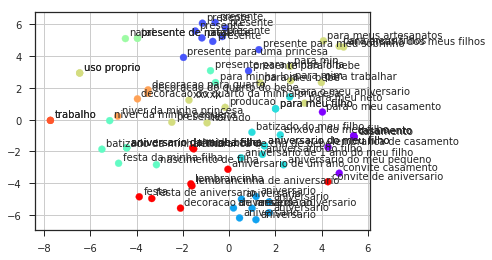

In [46]:
# Apresenta o resultado do T-SNE de duas dimensões com as cores
# indicando cada um dos clusters pré-definidos
labels_sample = df['labels'].values
titles_sample = df['reason'].values

plt.scatter(X_tsne[:, 0],
            X_tsne[:, 1],
            c=labels_sample,
            cmap='rainbow')

for i in range(X_tsne.shape[0]):
    # Anota os motivos no gráfico
    plt.annotate(titles_sample[i][:100], 
                 ((X_tsne[i, 0], X_tsne[i, 1])),
                 xytext=(4, 3), 
                 textcoords='offset points')
plt.grid()
plt.show()

# Topic Analysis

Até agora, nós utilizamos diversos algoritmos de clustering e redução de dimensionalidade para conseguir encontrar relações de proximidade entre documentos. Entretanto, apesar de algoritmos como o PCA conseguirem representar reduzidamente o nosso conjunto de documentos, nós não conseguíamos interpretar o resultado obtido. Isso acontece porque o PCA encontra novos vetores de features que são combinações lineares do conjunto de palavras existentes. Esse fator pode não ser um problema se o que se deseja é apenas encontrar clusters sem interpretações mais profundas. Entretanto, muitas vezes gostaríamos de entender o racional por trás da geração dos clusters. Ainda mais, as vezes gostaríamos de reduzir um documento a um conjunto de palavras-chave que podem "resumir" o nosso documento e agrupá-las em **tópicos**. E é exatamente esse o objetivo dessa aula.

A área de topic analysis é de grande importância para Machine Learning, ou mais especificamente a área de Data Mining. A utilização de tópicos nos permite ter uma melhor e mais compacta representação dos nossos dados, principalmente quando temos um conjunto extenso de dados e atributos (features). 

Utilizar topic analysis em Natural Language Processing (NLP) é algo bem intuitivo. Nós naturalmente fazemos isso quando queremos organizar textos (documentos) em diferentes categorias, ou temas. Por exemplo, nós podemos ler artigos do Google News e dizer facilmente que um determinado artigo tem o tema "esporte", ou o tema "política". Nosso trabalho em topic analysis é o de conseguir desenvolver algoritmos de Machine Learning que possam encontrar automaticamente esses tópicos, ou temas, por nós.

## Non-Negative Matrix Factorization NMF

O [NMF](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) é um algoritmo poderoso (apesar de relativamente simples) para encontrar tópicos em um conjunto de documentos e features. Ele se baseia em um processo de decomposição de matrizes para criar uma representação adequada da matriz de frequência de palavras (denotado por **A**). Mais especificamente, o NMF decompõe a matriz de frequência de palavras em duas: a primeira é a matriz de pesos (chamada de **W**), com as linhas representando os documentos e as colunas indicando os tópicos; e a segunda é a matriz de atributos (chamada de **H**), com as linhas indicando os tópicos e as colunas os atributos. O número de tópicos é definido antecipadamente e é fixo.

<img src="./imagens/nmf_draw.png" alt="Drawing" style="width: 500px;"/>

As duas matrizes são formadas a partir de um processo iterativo de otimização (veja esse [link](http://www.columbia.edu/~jwp2128/Teaching/E4903/papers/nmf_nature.pdf) para mais detalhes) com o objetivo de reconstruir fielmente a matriz **A**. Entretanto, para esse fim, a matriz **A** não pode possuir entradas negativas.

Vamos aplicar esse método na prática para verificar o resultado!

### Dataset Wikipedia

[pular](#Case-Elo7:-Motivos-de-Compra)

In [94]:
df_wiki = pd.read_csv(os.path.join(DATASET_FOLDER, 'wikipedia_dataset.csv'), sep=';')

df_wiki.head()

,titulo,artigo,cluster
0,Black Sabbath,"Black Sabbath are an English rock band, formed...",Music
1,Lymphoma,Lymphoma is a type of blood cancer that occurs...,Sickness
2,Hepatitis C,Hepatitis C is an infectious disease affecting...,Sickness
3,HTTP cookie,"A cookie, also known as an HTTP cookie, web co...",Internet
4,Global warming,Global warming is the rise in the average temp...,Global_Warming


In [95]:
tfidf = TfidfVectorizer(max_df=0.8, max_features=15000, sublinear_tf=True, use_idf=True)

X = tfidf.fit_transform(df_wiki['artigo'].values)

In [96]:
# Primeiro, importe o módulo NMF do scikit-learn
from sklearn.decomposition import NMF

# Precisamos criar a instância do NMF
# Temos que definir um número de componentes para o NMF
# Como temos 6 clusters, vamos escolher n_components=6
nmf = NMF(n_components=6)

# Agora vamos utilizar os mesmos atributos fit, transform ou fit_transform
# que já conhecemos do universo do sklearn
W_nmf = nmf.fit_transform(X)

# Vamos ver qual é a dimensão de W_nmf
W_nmf.shape

(58, 6)

Note que o número de linhas se manteve em 58, que é o número de documentos (artigos) que nós temos, e o número de colunas se transformou em 6, que é o número de tópicos que nós escolhemos. Essa matriz gerada representa a matriz **W** (matriz de pesos) da fatoração de matrizes.

Vamos agora achar a matriz **H** que representa a matriz de atributos.

In [97]:
H_nmf = nmf.components_
H_nmf.shape

(6, 15000)

Note que o número de linhas é igual ao número de tópicos e o número de colunas representa o número de palavras no nosso vocabulário. Cada linha da matriz é definida como um componente (assim como o PCA possui os componentes principais) que está associado a um tópico específico. Entretanto, diferentemente do PCA, nós podemos associar cada componente a um conjunto específico de palavras. Vamos verificar abaixo:

In [98]:
# Precisamos criar uma lista de palavras que representam as 
# colunas da matriz de frequência de palavras
words = [x[0] for x in sorted(tfidf.vocabulary_.items())]

# Vamos criar um dataframe para visualizar
components_df = pd.DataFrame(nmf.components_, columns=words)

# Vamos verificar as palavras que representam cada um dos tópicos
for i in range(6):
    component = components_df.iloc[i]
    print("Topico {}:".format(i))
    print("----------")
    print(component.nlargest(10))
    print("----------")

Topico 0:
----------
film       0.229718
she        0.216254
starred    0.190479
her        0.186661
award      0.161869
actress    0.152165
role       0.150504
actor      0.144441
drama      0.134471
cast       0.130892
Name: 0, dtype: float64
----------
Topico 1:
----------
treatment    0.162437
disease      0.138709
symptoms     0.134139
infection    0.130463
blood        0.121132
cell         0.113392
patients     0.107658
chronic      0.103009
cause        0.099644
acute        0.098949
Name: 1, dtype: float64
----------
Topico 2:
----------
cup         0.131864
scored      0.126404
fifa        0.117036
goals       0.113177
team        0.108451
goal        0.108346
match       0.105955
football    0.105514
uefa        0.102102
matches     0.097189
Name: 2, dtype: float64
----------
Topico 3:
----------
climate       0.229824
emissions     0.189640
conference    0.131711
greenhouse    0.126185
change        0.121271
global        0.116724
gas           0.116086
kyoto         0.1141

O que achou da distribuição de palavras dentro de cada tópico? Acha que faz sentido com os temas principais dos artigos do Wikipedia? Cada um dos tópicos poderia ser associado a um cluster?

Podemos ainda verificar quais são os tópicos principais de alguns artigos específicos.

In [99]:
# Precisamos criar um dataframe para facilitar nossa vida
df = pd.DataFrame(W_nmf, index=df_wiki['titulo'])

examples = ['Denzel Washington','Leukemia','Neymar','LinkedIn','Arctic Monkeys','Global warming']

for ex in examples:
    print('Artigo: {}'.format(ex))
    print('-'*30)
    print('Topico\tDist.\tPalavras')
    print('-'*30)
    for i,topic in enumerate(df.loc[ex]):
        words = components_df.iloc[i].nlargest(5).index.tolist()
        print('{}\t{:.2f}\t{}'.format(i,topic,', '.join(words)))
    print()

Artigo: Denzel Washington
------------------------------
Topico	Dist.	Palavras
------------------------------
0	0.31	film, she, starred, her, award
1	0.00	treatment, disease, symptoms, infection, blood
2	0.02	cup, scored, fifa, goals, team
3	0.00	climate, emissions, conference, greenhouse, change
4	0.00	users, web, search, google, user
5	0.00	album, band, song, tour, songs

Artigo: Leukemia
------------------------------
Topico	Dist.	Palavras
------------------------------
0	0.01	film, she, starred, her, award
1	0.49	treatment, disease, symptoms, infection, blood
2	0.00	cup, scored, fifa, goals, team
3	0.00	climate, emissions, conference, greenhouse, change
4	0.00	users, web, search, google, user
5	0.00	album, band, song, tour, songs

Artigo: Neymar
------------------------------
Topico	Dist.	Palavras
------------------------------
0	0.02	film, she, starred, her, award
1	0.00	treatment, disease, symptoms, infection, blood
2	0.51	cup, scored, fifa, goals, team
3	0.00	climate, emissions,

Podemos notar que os artigos possuem tópicos coerentes com o que esperávamos!

Vamos agrupar agora os artigos pelos tópicos principais de cada um deles e ver como eles tém relação com os clusters definidos anteriormente.

In [100]:
# Cria as labels a partir do tópico mais relevante de cada artigo
labels = np.argmax(W_nmf, axis=1)

# Cria o novo dataframe com os labels dos clusters
df = pd.DataFrame({'label': labels, 'article': df_wiki['titulo']})

# Apresenta os resultados
print(df.sort_values(by='label'))

    label                                        article
10      0                                   Jessica Biel
19      0                                 Angelina Jolie
18      0                                     Mila Kunis
38      0                                  Anne Hathaway
5       0                           Catherine Zeta-Jones
46      0                             Michael Fassbender
7       0                              Denzel Washington
50      0                               Jennifer Aniston
25      0                                 Dakota Fanning
12      0                                  Russell Crowe
49      1                                    Tonsillitis
31      1                                       Leukemia
24      1                                          Fever
52      1                                     Prednisone
9       1                                           Gout
8       1                                    Hepatitis B
34      1                      

Só por diversão, vamos verificar como ficaria um agrupamento usando Hierarchical Clustering na matriz de atributos obtida pelo NMF.

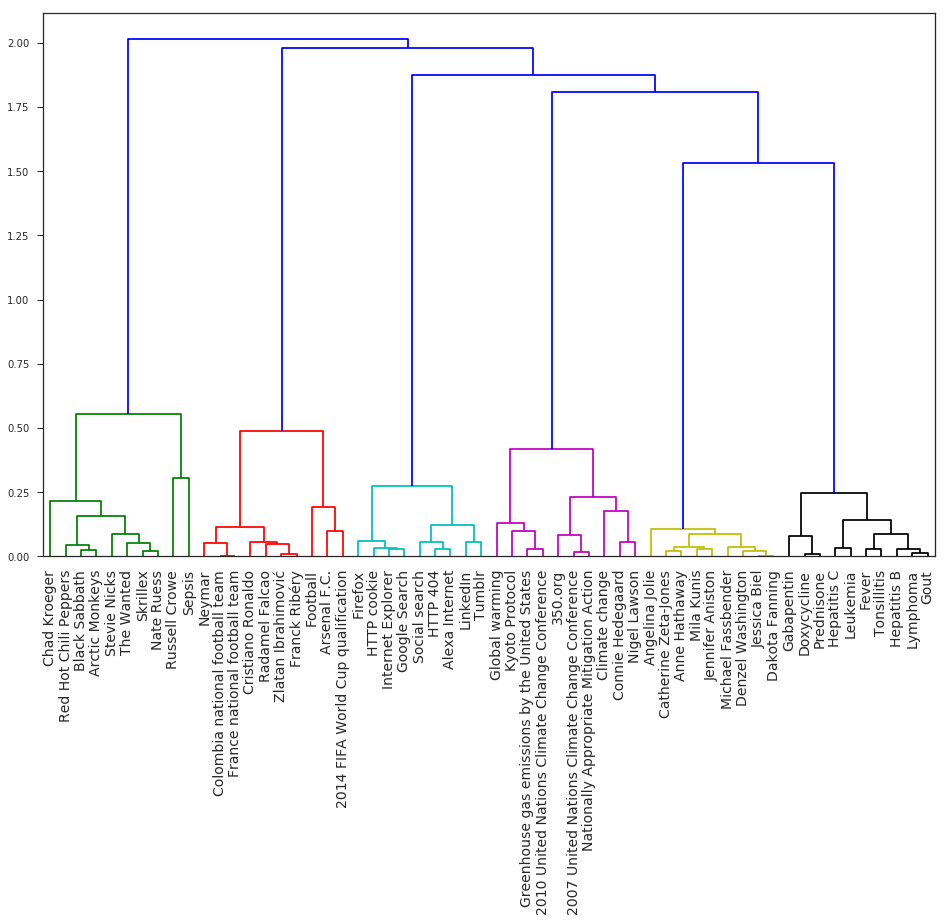

In [101]:
from scipy.cluster.hierarchy import linkage, dendrogram

Y = linkage(W_nmf, method='ward', metric='euclidean')

dendrogram(Y,
           labels=df_wiki['titulo'].values,
           leaf_rotation=90,
           leaf_font_size=14,
)
plt.show()

### Case Elo7: Motivos de Compra

Agora aplique o NMF no dataset de motivos de compra e verifique o resultado comparado ao PCA.

In [102]:
df_reason.head()

,product_title,reason
0,apliques recortados fundo do mar,festa de 2 anos do meu filho
1,mini raposa vermelha amigurumi,presente para mim
2,o pequeno principe i bata,aniversario
3,quadro maternidade menino elefante,nascimento do meu bebe
4,livro de votos casamento o par,casamento


In [103]:
tfidf = TfidfVectorizer(max_df=0.8, max_features=5000, sublinear_tf=True, use_idf=True)

X = tfidf.fit_transform(df_reason['reason'].values)

In [104]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=20)

# Aplique o método SVD
W_nmf = nmf.fit_transform(X)

# Vamos ver como ficou o novo tamanho
W_nmf.shape

(100000, 20)

In [105]:
# Precisamos criar uma lista de palavras que representam as 
# colunas da matriz de frequência de palavras
words = [x[0] for x in sorted(tfidf.vocabulary_.items())]

# Vamos criar um dataframe para visualizar
components_df = pd.DataFrame(nmf.components_, columns=words)

# Vamos verificar as palavras que representam cada um dos tópicos
for i in range(W_nmf.shape[1]):
    component = components_df.iloc[i]
    print("Topico {}:".format(i))
    print("----------")
    print(component.nlargest(10))
    print("----------")

Topico 0:
----------
aniversario      12.530489
da                0.140119
ano               0.070470
infantil          0.060512
filhos            0.051727
dos               0.036775
meus              0.030062
lembranca         0.028891
lembrancinhas     0.027762
sobrinha          0.027352
Name: 0, dtype: float64
----------
Topico 1:
----------
presente     10.671337
amiga         0.117963
um            0.117091
natal         0.103644
principe      0.095000
sobrinha      0.084606
padrinhos     0.061403
uma           0.056301
filha         0.056259
pra           0.054643
Name: 1, dtype: float64
----------
Topico 2:
----------
casamento        9.663153
convite          0.192690
padrinhos        0.079060
convites         0.061378
lembrancas       0.020893
meu              0.016339
madrinhas        0.015956
nosso            0.013103
lembranca        0.011499
lembrancinhas    0.005855
Name: 2, dtype: float64
----------
Topico 3:
----------
filha         6.999644
minha         5.415370
da   

In [106]:
# Cria as labels a partir do tópico mais relevante de cada artigo
labels = np.argmax(W_nmf, axis=1)

# Cria o novo dataframe com os labels dos clusters
df = pd.DataFrame({'label': labels, 'reason': df_reason['reason']})

# Pega um sample
df_sample = df.sample(n=60)

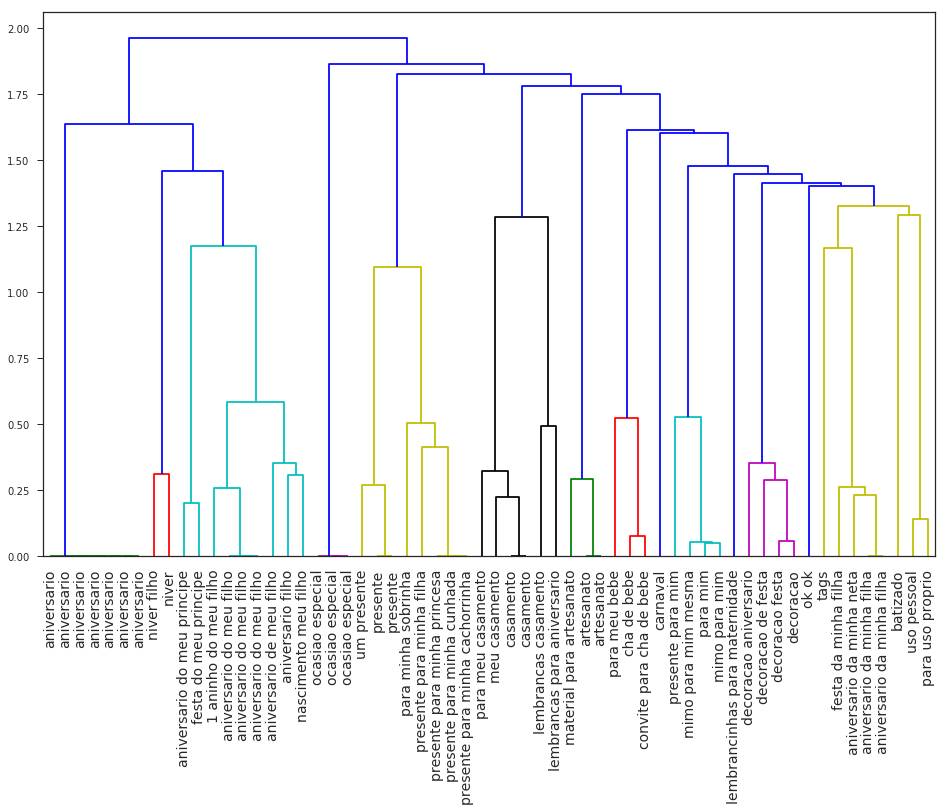

In [107]:
from scipy.cluster.hierarchy import linkage, dendrogram

X_sample = df_sample['reason'].values

W_nmf = nmf.fit_transform(tfidf.fit_transform(X_sample))

Y = linkage(W_nmf, method='ward', metric='euclidean')

dendrogram(Y,
           labels=df_sample['reason'].values,
           leaf_rotation=90,
           leaf_font_size=14,
)
plt.show()

## Latent Dirichlet Allocation LDA

Assim como o NMF, o [LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) é um algoritmo relativamente simples (pelo menos algoritmicamente) e poderoso para conseguir encontrar tópicos dentro de documentos. Entretanto, diferentemente do NMF, o LDA se baseia em métodos probabilísticos. Mais especificamente, o **LDA** assume que cada **documento** foi gerado a partir de uma **mistura de tópicos** com uma distribuição de probabilidade (no caso, uma distribuição [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution)), e cada **tópico** foi gerado por uma distribuição de **palavras** com certa probabilidade associada (distribuição [multinomial](https://en.wikipedia.org/wiki/Multinomial_distribution)).

Para imaginar um cenário, imagine que temos os seguintes documentos (retirados deste [link](https://www.quora.com/What-is-a-good-explanation-of-Latent-Dirichlet-Allocation)):
1. I ate a banana and spinach smoothie for breakfast
2. I like to eat broccoli and bananas.
3. Chinchillas and kittens are cute.
4. My sister adopted a kitten yesterday.
5. Look at this cute hamster munching on a piece of broccoli.

Para o LDA, os documentos poderiam ser formados pelos seguintes tópicos e palavras:
- Documentos 1 e 2: 100% Tópico A
- Documentos 3 e 4: 100% Tópico B
- Documento 5: 60% Tópico A, 40% Tópico B

- Tópico A: 30% broccoli, 15% bananas, 10% breakfast, 10% munching (Talvez represente algo relacionado a comida)
- Tópico B: 20% chinchillas, 20% kittens, 20% cute, 15% hamster (Talvez seja relacionado a animais fofinhos)

Esse comportamento do LDA é interessante, já que temos uma representação mais intuitiva da formação dos documentos. Poderíamos até criar documentos artificiais a partir dessas definições.

### Dataset Wikipedia
[pular]()

In [108]:
df_wiki = pd.read_csv(os.path.join(DATASET_FOLDER, 'wikipedia_dataset.csv'), sep=';')

df_wiki.head()

,titulo,artigo,cluster
0,Black Sabbath,"Black Sabbath are an English rock band, formed...",Music
1,Lymphoma,Lymphoma is a type of blood cancer that occurs...,Sickness
2,Hepatitis C,Hepatitis C is an infectious disease affecting...,Sickness
3,HTTP cookie,"A cookie, also known as an HTTP cookie, web co...",Internet
4,Global warming,Global warming is the rise in the average temp...,Global_Warming


O LDA não pode ser utilizado com Tf-Idf, porque ele precisa da contagem total de palavras nos documentos. Por esse motivo, vamos utilizar o método [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) do scikit-learn. Esse método apenas realiza a contagem de frequência de palavras nos documentos. Para evitar que "stopwords" tenham uma importância indevida, podemos remove-las do texto.

In [109]:
# Importa o módulo CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tf = CountVectorizer(max_df=0.95, min_df=0.01, max_features=15000, stop_words='english')

X = tf.fit_transform(df_wiki['artigo'].values)

In [110]:
# Agora vamos importar o módulo LDA do scikit-learn
from sklearn.decomposition import LatentDirichletAllocation

# Precisamos criar a instância do LDA
# Temos que definir um número de tópicos do LDA
# Como temos 6 clusters, vamos escolher n_topics=6
lda = LatentDirichletAllocation(n_topics=6, learning_method='batch')

# Agora vamos utilizar os mesmos atributos fit, transform ou fit_transform
# que já conhecemos do universo do sklearn
X_lda = lda.fit_transform(X)

# Vamos ver qual é a dimensão de X_lda
X_lda.shape

/home/rballet/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


(58, 6)

Note que o número de linhas se manteve em 58, que é o número de documentos (artigos) que nós temos, e o número de colunas se transformou em 6, que é o número de tópicos que nós escolhemos. 

Vamos agora achar a matriz de atributos.

In [111]:
# Normaliza os componentes
lda_components = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
print(lda_components.shape)

(6, 15000)


Note que o número de linhas é igual ao número de tópicos e o número de colunas representa o número de palavras no nosso vocabulário. Essa matriz é semelhante a matriz de atributos do NMF.

Vamos achar quais são as palavras mais importantes para cada tópico.

In [112]:
# Precisamos criar uma lista de palavras que representam as 
# colunas da matriz de frequência de palavras
words = [x[0] for x in sorted(tf.vocabulary_.items())]

# Vamos criar um dataframe para visualizar
components_df = pd.DataFrame(lda_components, columns=words)

# Vamos verificar as palavras que representam cada um dos tópicos
for i in range(6):
    component = components_df.iloc[i]
    print("Topico {}:".format(i))
    print("----------")
    print(component.nlargest())
    print("----------")

Topico 0:
----------
internet    0.009296
explorer    0.007927
jolie       0.006203
cookies     0.005959
user        0.005223
Name: 0, dtype: float64
----------
Topico 1:
----------
ronaldo    0.010579
scored     0.009776
goal       0.009726
team       0.008595
league     0.008130
Name: 1, dtype: float64
----------
Topico 2:
----------
climate      0.014169
emissions    0.012211
global       0.008332
change       0.007822
countries    0.006237
Name: 2, dtype: float64
----------
Topico 3:
----------
band        0.029425
album       0.022181
tour        0.010845
released    0.008942
sabbath     0.008405
Name: 3, dtype: float64
----------
Topico 4:
----------
nicks       0.011958
iron        0.005649
leukemia    0.005034
album       0.004988
blood       0.004223
Name: 4, dtype: float64
----------
Topico 5:
----------
film        0.012479
football    0.010038
search      0.006835
google      0.006323
firefox     0.005302
Name: 5, dtype: float64
----------


O que achou da distribuição de palavras dentro de cada tópico? Acha que faz sentido com os temas principais dos artigos do Wikipedia? Cada um dos tópicos poderia ser associado a um cluster?

Podemos ainda verificar quais são os tópicos principais de alguns artigos específicos.

In [113]:
# Precisamos criar um dataframe para facilitar nossa vida
df = pd.DataFrame(X_lda, index=df_wiki['titulo'])

examples = ['Denzel Washington','Leukemia','Neymar','LinkedIn','Arctic Monkeys','Global warming']

for ex in examples:
    print('Artigo: {}'.format(ex))
    print('-'*30)
    print('Topico\tDist.\tPalavras')
    print('-'*30)
    for i,topic in enumerate(df.loc[ex]):
        words = components_df.iloc[i].nlargest(5).index.tolist()
        print('{}\t{:.2f}\t{}'.format(i,topic,', '.join(words)))
    print()

Artigo: Denzel Washington
------------------------------
Topico	Dist.	Palavras
------------------------------
0	0.00	internet, explorer, jolie, cookies, user
1	0.00	ronaldo, scored, goal, team, league
2	0.00	climate, emissions, global, change, countries
3	0.76	band, album, tour, released, sabbath
4	0.00	nicks, iron, leukemia, album, blood
5	0.24	film, football, search, google, firefox

Artigo: Leukemia
------------------------------
Topico	Dist.	Palavras
------------------------------
0	0.10	internet, explorer, jolie, cookies, user
1	0.17	ronaldo, scored, goal, team, league
2	0.08	climate, emissions, global, change, countries
3	0.00	band, album, tour, released, sabbath
4	0.65	nicks, iron, leukemia, album, blood
5	0.00	film, football, search, google, firefox

Artigo: Neymar
------------------------------
Topico	Dist.	Palavras
------------------------------
0	0.00	internet, explorer, jolie, cookies, user
1	1.00	ronaldo, scored, goal, team, league
2	0.00	climate, emissions, global, change

In [114]:
# Cria as labels a partir do tópico mais relevante de cada artigo
labels = np.argmax(X_lda, axis=1)

# Cria o novo dataframe com os labels dos clusters
df = pd.DataFrame({'label': labels, 'titulo': df_wiki['titulo']})

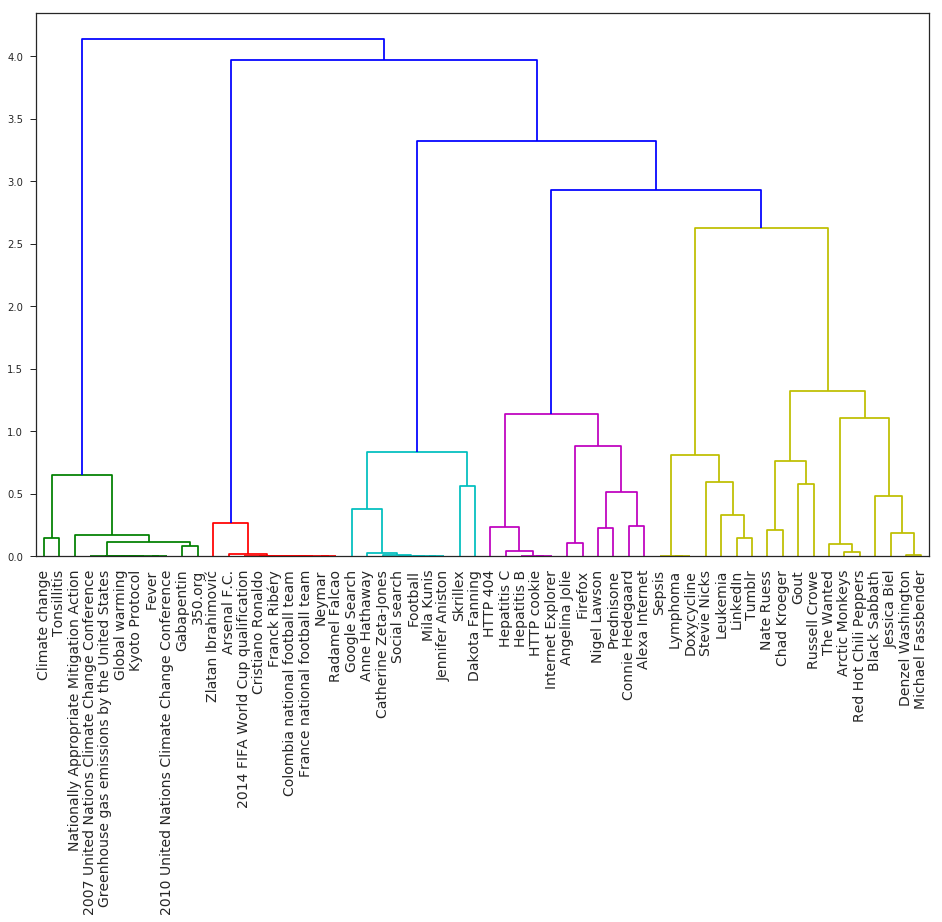

In [115]:
Y = linkage(X_lda, method='ward', metric='euclidean')

dendrogram(Y,
           labels=df_wiki['titulo'].values,
           leaf_rotation=90,
           leaf_font_size=14,
)
plt.show()

---
# Case NY Times

In [69]:
df_nyt = pd.read_csv(os.path.join(DATASET_FOLDER, 'nyt_dataset.csv'), sep=';')

df_nyt.head()

,company,percent,state,play,official,game,man,city,plan,school,...,speculate,thrill,spur,vivid,exact,helpful,distinguish,glad,harder,lucrative
0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
X = df_nyt.values

In [71]:
# Primeiro, importe o módulo NMF do scikit-learn
from sklearn.decomposition import NMF

# Precisamos criar a instância do NMF
# Vamos escolher 25 tópicos
n_topics = 25
nmf = NMF(n_components=n_topics)

# Agora vamos utilizar os mesmos atributos fit, transform ou fit_transform
# que já conhecemos do universo do sklearn
W_nmf = nmf.fit_transform(X)

# Vamos ver qual é a dimensão de W_nmf
W_nmf.shape

(8447, 25)

Note que o número de linhas se manteve em 8447, que é o número de documentos (artigos) que nós temos, e o número de colunas se transformou em 25, que é o número de tópicos que nós escolhemos. Essa matriz gerada representa a matriz **W** (matriz de pesos) da fatoração de matrizes.

Vamos agora achar a matriz **H** que representa a matriz de atributos.

In [72]:
H_nmf = nmf.components_
H_nmf.shape

(25, 3012)

Note que o número de linhas é igual ao número de tópicos e o número de colunas representa o número de palavras no nosso vocabulário. Cada linha da matriz é definida como um componente (assim como o PCA possui os componentes principais) que está associado a um tópico específico. Entretanto, diferentemente do PCA, nós podemos associar cada componente a um conjunto específico de palavras. Vamos verificar abaixo:

In [73]:
# Precisamos criar uma lista de palavras que representam as 
# colunas da matriz de frequência de palavras
words = df_nyt.columns

# Vamos criar um dataframe para visualizar
components_df = pd.DataFrame(H_nmf, columns=words)

# Vamos verificar as palavras que representam cada um dos tópicos
for i in range(n_topics):
    component = components_df.iloc[i]
    print("Topico {}:".format(i))
    print("----------")
    print(component.nlargest())
    print("----------")

Topico 0:
----------
computer      3.980354
system        3.906170
service       3.466818
technology    2.569710
offer         2.551096
Name: 0, dtype: float64
----------
Topico 1:
----------
thing    4.067100
ask      3.087598
feel     2.585458
tell     2.518143
lot      2.288177
Name: 1, dtype: float64
----------
Topico 2:
----------
company     6.188070
business    2.556170
sell        2.403194
share       2.131945
stock       1.995125
Name: 2, dtype: float64
----------
Topico 3:
----------
team      4.779742
play      4.118846
player    4.069286
game      3.960335
season    3.399972
Name: 3, dtype: float64
----------
Topico 4:
----------
states        5.265846
american      5.019282
country       4.386792
government    2.851587
world         2.033828
Name: 4, dtype: float64
----------
Topico 5:
----------
police     4.466648
officer    2.666305
kill       2.635043
man        2.299785
attack     1.755123
Name: 5, dtype: float64
----------
Topico 6:
----------
pay       3.204837
mone

In [74]:
# Nós vamos ter que normalizar o vetor de atributos
# Isso é necessário para que todas as features (tópicos) 
# de um documento some 1 ao final
# Seria a porcentagem de composição dos tópicos 
# no documento
from sklearn.preprocessing import normalize
W_nmf_norm = normalize(W_nmf)

In [75]:
# Vamos criar um dataframe:
# índice: documento
# colunas: vetor de features (normalizadas)
df = pd.DataFrame(W_nmf_norm,
                  columns=['topic {}'.format(i) for i in range(n_topics)],
                  index=['doc {}'.format(i) for i in range(len(df_nyt))])
df.head(5)

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,...,topic 15,topic 16,topic 17,topic 18,topic 19,topic 20,topic 21,topic 22,topic 23,topic 24
doc 0,0.000000,0.029083,0.000000,0.000000,0.164443,0.000000,0.000000,0.260511,0.445799,0.000000,...,0.009712,0.000000,0.000000,0.118227,0.000000,0.000000,0.005267,0.007626,0.059045,0.000000
doc 1,0.015091,0.641312,0.038600,0.006348,0.643614,0.065134,0.092993,0.000000,0.045603,0.128840,...,0.205307,0.041918,0.035956,0.173373,0.000000,0.000000,0.092630,0.014766,0.202755,0.024505
doc 2,0.594973,0.548162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.088004,0.000000,0.467714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
doc 3,0.083209,0.098746,0.150544,0.071927,0.204056,0.000000,0.026858,0.021777,0.421658,0.057165,...,0.102156,0.004721,0.080371,0.211727,0.211069,0.633582,0.006790,0.015570,0.198494,0.031387
doc 4,0.049224,0.101826,0.000000,0.001572,0.000000,0.168074,0.000000,0.000000,0.033440,0.038354,...,0.000000,0.118807,0.007665,0.000000,0.000000,0.000000,0.493409,0.000000,0.000000,0.053997


In [76]:
# Vamos pegar o mesmo artigo escolhido anteriormente
doc_target

3644

In [77]:
# Verifica o vetor de features dele:
doc_target_features = df.iloc[doc_target]
print(doc_target_features)

topic 0     0.000000
topic 1     0.133632
topic 2     0.023141
topic 3     0.000000
topic 4     0.000000
topic 5     0.000000
topic 6     0.000000
topic 7     0.499326
topic 8     0.059256
topic 9     0.000000
topic 10    0.272656
topic 11    0.551303
topic 12    0.000000
topic 13    0.000000
topic 14    0.000000
topic 15    0.000000
topic 16    0.000000
topic 17    0.000000
topic 18    0.000000
topic 19    0.000000
topic 20    0.000000
topic 21    0.575150
topic 22    0.093209
topic 23    0.000000
topic 24    0.104914
Name: doc 3644, dtype: float64


In [78]:
# Calcula a similaridade de cossenos entre o artigo e 
# todos os outros documentos
cossine_similarity = df.dot(doc_target_features)

# Todos os documentos com maior similaridade de cossenos 
# representam os documentos mais próximos
print("Artigos recomendados:")
recommendations = cossine_similarity.nlargest(6)[1:]
print(recommendations)

Artigos recomendados:
doc 5570    0.912400
doc 1498    0.794600
doc 5388    0.762705
doc 6935    0.752985
doc 5664    0.750033
dtype: float64


In [79]:
default_top_topics = df.iloc[doc_target].nlargest(3).index.values
default_components = [components_df.iloc[int(i.split(' ')[1])].nlargest(5).index.values 
                      for i in default_top_topics]

print("Artigo original: doc {}".format(doc_target))
print("-----------------------")
print("- Tópicos (palavras): ")
for i in range(len(default_top_topics)):
    print("{:>15} ({})".format(default_top_topics[i], ', '.join(default_components[i])))
print("\n\n")

for doc, similarity in recommendations.items():
    doc_num = int(doc.split(' ')[1])
    top_topics = df.iloc[doc_num].nlargest(3).index.values
    components = [components_df.iloc[int(i.split(' ')[1])].nlargest(5).index.values for i in top_topics]
    print("Recomendação {}:".format(doc))
    print("-----------------------")
    print("- Similaridade: {:.2%}".format(similarity))
    print("- Tópicos (palavras): ")
    for i in range(len(top_topics)):
        print("{:>15} ({})".format(top_topics[i], ', '.join(components[i])))
    print("\n")

Artigo original: doc 3644
-----------------------
- Tópicos (palavras): 
       topic 21 (woman, family, child, man, life)
       topic 11 (president, executive, director, chief, vice)
        topic 7 (serve, add, minute, food, pepper)



Recomendação doc 5570:
-----------------------
- Similaridade: 91.24%
- Tópicos (palavras): 
       topic 21 (woman, family, child, man, life)
        topic 7 (serve, add, minute, food, pepper)
       topic 10 (art, artist, exhibition, museum, painting)


Recomendação doc 1498:
-----------------------
- Similaridade: 79.46%
- Tópicos (palavras): 
       topic 10 (art, artist, exhibition, museum, painting)
        topic 7 (serve, add, minute, food, pepper)
       topic 21 (woman, family, child, man, life)


Recomendação doc 5388:
-----------------------
- Similaridade: 76.27%
- Tópicos (palavras): 
       topic 21 (woman, family, child, man, life)
       topic 11 (president, executive, director, chief, vice)
       topic 10 (art, artist, exhibition, mu

---
# Recomendação com Filtro Colaborativo

## Case: Recomendação Filmes

Este case foi tema de um dos processos seletivos que utilizamos para uma vaga de Data Scientist no Elo7! A descrição exata deste teste pode ser encontrada nesse [notebook](teste_data_science.ipynb). A descrição foi feita, na época, pelo André "Bolinho" Barbosa.

Este dataset é muito utilizado na área de recomendação para testar algoritmos de recomendação. O objetivo dele é tentar prever a avaliação (de 1 a 5) que um usuário daria para um filme que ele ainda não viu baseado em outros filmes que ele avaliou. Esse dataset foi retirado do [MovieLens](https://grouplens.org/datasets/movielens/) e contém 100004 avaliações de 671 usuários a 9125 filmes.



In [80]:
df_movies = pd.read_csv(os.path.join(DATASET_FOLDER,'movie_lens_dataset.csv'))

df_movies.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [81]:
df_movies_pivot = df_movies.pivot_table(values='rating',index='userId',columns='movieId').fillna(0)
df_movies_pivot.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
X = df_movies_pivot.values

In [83]:
print('Esparsidade: {:.2%}'.format(len(X[X==0])/np.prod(X.shape)))

Esparsidade: 98.36%


Existem muitos campos vazios, ou seja, sem avaliação. Na área de sistemas de recomendação, isso não representa que esses usuários não se interessaram por esses filmes, mas sim que eles não tiveram a oportunidade de avaliá-los. Dessa forma, o que gostaríamos é de predizer qual seria a avaliação de um usuário de um filme não visto por ele. Filmes que possuírem as melhores avaliações preditas serão recomendados para o usuário. Parece bem simples, não?

A técnica de filtro colaborativo é muito utilizada para recomendação de filmes. A ideia do filtro colaborativo é utilizar a "inteligência da população" para ajudar a prever o comportamento de um indivíduo. Por exemplo, seria intuitivo pensar que se dois usuários assistem e avaliam filmes semelhantemente, nós podemos utilizar a avaliação de um dos usuários para prever avaliação do outro. Essa ideia está representada na figura abaixo.

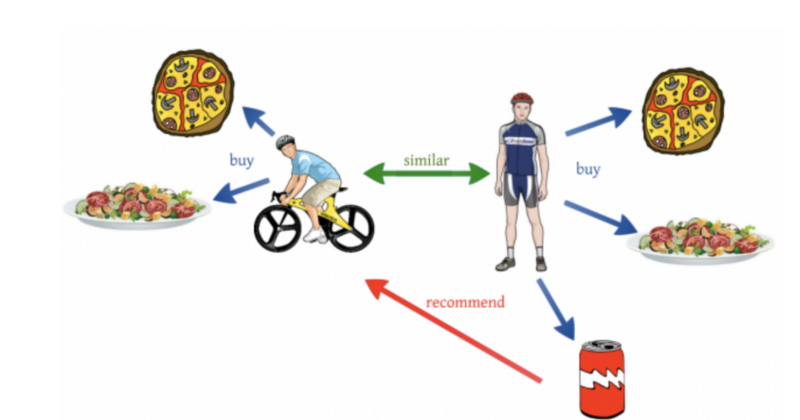

O método de Filtro Colaborativo possui duas vertentes principais. A primeira é baseada em **memória** e a segunda é baseada em **modelo**. Abaixo apresento as duas formas.

### Filtro colaborativo baseado em memória

Esse método é dito que é baseado em memória porque não procura modelar o interesse do usuário de alguma forma (método não paramétrico). O que ele faz é tentar predizer a avaliação de um usuário para um determinado item ao ponderar as votações de usuários semelhantes a ele. Quanto mais próximos são os usuários, maior é a valor dado para a votação desse usuário na ponderação.

O filtro colaborativo baseado em memória é ainda dividido em duas áreas principais:

- Filtro Colaborativo Item-Item: “Usuários que gostaram disso também gostaram ...”

    Esse método utiliza a proximidade entre itens para recomendar outros itens para um usuário. Itens são considerados semelhantes se forem avaliados de forma semelhante pelos usuários.


- Filtro Colaborativo Usuário-Item: “Usuários semelhantes a você gostaram ...”
    
    Diferentemente do método anterior, esse método utiliza a proximidade entre usuários para recomendar outros itens para um usuário. Usuários são considerados semelhantes se eles avaliam semelhantemente os itens consumidos. Por exemplo, se o usuário A e B avaliam os filmes X e Y de maneira semelhante, mas só o usuário B avaliou de forma positiva o filme Z, seria intuitivo recomendar o filme Z para o usuário A.

Vamos testar os dois métodos!

Vamos primeiro criar um dataset de treino e teste.

In [84]:
# Gera um conjunto aleatório das avaliações
df_movies = df_movies.sample(frac=1)

# Escolhe um corte para escolher os dados de treino e teste
train_ratio = 0.75
threshold = int(train_ratio * len(df_movies))

train_movies = df_movies[:threshold]
test_movies = df_movies[threshold:]

In [85]:
# Vamos criar as matrizes de treino e teste
X_train = train_movies.pivot_table(values='rating',index='userId',columns='movieId').fillna(0).values
X_test = test_movies.pivot_table(values='rating',index='userId',columns='movieId').fillna(0).values

Vamos agora calcular as similaridades entre itens e usuários.

In [86]:
from sklearn.metrics.pairwise import pairwise_distances

user_similarity_matrix = pairwise_distances(X_train, metric='cosine')
item_similarity_matrix = pairwise_distances(X_train.T, metric='cosine')

Vamos criar uma função que prediz a avaliação do usuário baseado em similaridades de itens e de usuários.

In [87]:
def predict(X, similarity_matrix, type='user'):
    if type == 'user':
        X_mean = np.mean(X, axis=1)[:, np.newaxis]
        # retiramos a média dos dados
        X_diff = (X - X_mean)
        # Adiciona a média de avaliação dos usuários
        # Usuários possuem um viés de votação, 
        # portanto consideramos esse viés na nossa predição
        pred = X_mean + similarity_matrix.dot(X_diff) / np.array([np.abs(similarity_matrix).sum(axis=1)]).T
    elif type == 'item':
        pred = X.dot(similarity_matrix) / np.array([np.abs(similarity_matrix).sum(axis=1)])
    return pred

Gera as predições.

In [88]:
item_prediction = predict(X_train, item_similarity_matrix, type='item')
user_prediction = predict(X_train, user_similarity_matrix, type='user')

Para avaliar a predição, nós vamos utilizar o "root mean squared error" (rmse). Essa métrica é comumente utilizada para avaliar a magnitude dos erros de predição de regressores. Quanto menor o valor do `rmse`, melhor a precisão do nosso recomendador.

In [89]:
from sklearn.metrics import mean_squared_error

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    
    return np.sqrt(mean_squared_error(prediction, ground_truth))

In [90]:
print('Filtro colaborativo User-Item RMSE: {:.4f}'.format(rmse(user_prediction, X_test)))
print('Filtro colaborativo Item-Item RMSE: {:.4f}'.format(rmse(item_prediction, X_test)))

Filtro colaborativo User-Item RMSE: 3.5233
Filtro colaborativo Item-Item RMSE: 3.5620


Os dois algoritmos parecem ter precisão semelhante, com uma leve vantagem do algoritmo User-Item.

---
### Filtro colaborativo baseado em modelo

O método apresentado aqui difere do modelo anterior ao tentar criar um modelo do usuário (método paramétrico). Existem diversos algoritmos que entram na definição de filtro colaborativo baseado em modelo, mas os mais comuns são baseados em [fatorização de matrizes](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf).

O objetivo principal da fatorização de matrizes é o de encontrar as características intrínsecas dos usuários e itens. Essas características podem explicar as motivações que levaram um usuário a avaliar esses itens.

A técnica mais famosa para fatorar matrizes em sistemas de recomendação é o [SVD](https://en.wikipedia.org/wiki/Singular-value_decomposition), principalmente depois que foi utilizada na [competição de recomendações do Netflix](https://medium.com/netflix-techblog/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429). A ideia principal do SVD pode ser vista na figura abaixo:

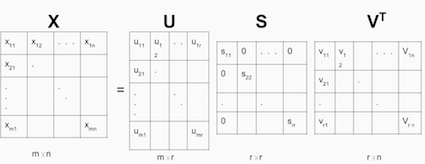

Nós temos a matriz X, que representa a matriz de usuários e itens avaliados. Nós podemos fatorar essa matriz para encontrar as matrizes U, S e V, onde a matriz U contém os componentes latentes dos usuários, a matriz S é uma matriz diagonal que contém os valores singulares de X e V contém os componentes latentes dos itens. Como a matriz X é uma matriz com alto grau de esparsidade (>90%), a fatoração não pode ser feita da maneira tradicional de álgebra. Contudo, existem aproximações que funcionam bem na prática, como a utilização do método do gradiente descendente ou do algoritmo ARPACK utilizado pelo `scipy`. A partir do momento que conseguimos encontrar as matrizes U, S e V, nós conseguimos calcular a nova matriz X', que é a predição dos valores de avaliação dos itens não avaliados anteriormente.

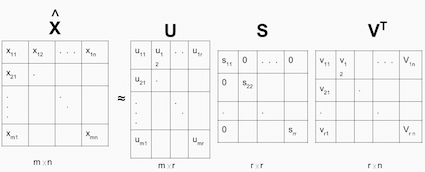

Vamos agora tentar utilizar esses conceitos para encontrar as recomendações dos filmes!

In [91]:
from scipy.sparse.linalg import svds

# Vamos fatorar a matriz de treino para encontrar as matrizes U,S e V
# Nós precisamos definir o número de variáveis latentes do sistema
# Teste valores diferentes de k para verificar a qualidade do resultado
u, s, vt = svds(X_train, k = 20)
s_diag_matrix = np.diag(s)

# Prediz as avaliações
X_pred = u.dot(s_diag_matrix).dot(vt)

# Verifica o resultado utilizando o RMSE
print('Filtro colaborativo SVD RMSE: {:.4f}'.format(rmse(X_pred, X_test)))

Filtro colaborativo SVD RMSE: 3.5112


Podemos notar que o filtro colaborativo utilizando o SVD possui uma precisão maior do que os métodos baseados em memória.

Que melhorias você faria no algoritmo para atingir um resultado ainda melhor? Leia [esse](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf) artigo que explica a utilização de fatorização de matrizes na competição da Netflix para mais ideias.